<a href="https://colab.research.google.com/github/XeniaLLL/ETM/blob/main/Demo_for_SemiUOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code Demo for SemiUOT

To start with, we should prepare the data.

In [ ]:
import numpy as np
import matplotlib.pylab as pl
import ot
import torch
import torch.nn as nn
import torch.optim as optim
import ot.plot
import cvxpy as cp

n = 50 # nb samples
n_noise = 10

mu_s = np.array([-1, -1])
cov_s = np.array([[1, 0], [0, 1]])

mu_t = np.array([4, 4])
cov_t = np.array([[1, -.8], [-.8, 1]])

np.random.seed(0)
xs = ot.datasets.make_2D_samples_gauss(n - n_noise, mu_s, cov_s)
xt = ot.datasets.make_2D_samples_gauss(n, mu_t, cov_t)

xs = np.concatenate((xs, ((np.random.rand(n_noise, 2) - 6))), axis=0)

a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

# loss matrix
cost = ot.dist(xs, xt)
cost /= cost.max()
tau = 0.1
eps = 0.01

In [ ]:
def semiuot_helper(cost, src_weight, trg_weight,
                   tau, eps = 0.01, epoch_iter = 50, tol = 1e-6):
    num_src_sample = cost.shape[0]
    u = np.ones((num_src_sample,)) / num_src_sample
    coef = tau * eps / (tau + eps)
    # First update on u and set zeta = 0
    for e in range(epoch_iter):
        prev_u = u
        den = np.sum(np.exp((u.reshape(-1, 1) - cost) / eps), axis=0)
        term = np.exp(-cost / eps) / den
        sum_term = np.sum(term * trg_weight.reshape(1, -1), axis=1)
        u = coef * (np.log(src_weight) - np.log(sum_term))

        if np.linalg.norm(prev_u - u) <= tol:
            print('Using Epoch to converge:', e)
            break
    # Find the value on zeta
    exp_u = np.exp(-u / tau)
    src_weight_sum = np.sum(src_weight * exp_u)
    trg_weight_sum = np.sum(trg_weight)
    zeta = tau * np.log(src_weight_sum/trg_weight_sum)
    # Obtain v and s accordingly.
    v = -eps * np.log(np.sum(np.exp((u.reshape(-1, 1) - cost) / eps), axis=0))
    s = np.maximum(0, cost - u.reshape(-1, 1) - v.reshape(1, -1))
    return u, v, zeta, s

In [ ]:
u, v, zeta, s = semiuot_helper(cost,
                     a,
                     b,
                     tau,
                     tau)
print('value of u: ', u)
print('value of v: ', v)
print('value of zeta: ', zeta)
print('value of s: ', s)

Using Epoch to converge: 18
value of u:  [-0.06307453 -0.08441071 -0.03039251 -0.03696579 -0.02900468 -0.05563174
 -0.04004656 -0.03880458 -0.04487102 -0.00618259  0.03227422 -0.02015429
 -0.02234363 -0.01804528 -0.08085915 -0.03387006  0.05621541 -0.017541
 -0.07120769 -0.0052876   0.04274764 -0.01881384  0.0011611  -0.00889366
  0.02449321 -0.00956333  0.0218219  -0.03106    -0.03025352  0.00223925
  0.00310049  0.04607078 -0.01542531  0.00854012 -0.00133104 -0.03961705
 -0.01135563 -0.01265755  0.01391998 -0.01598763  0.29270648  0.28380334
  0.28247415  0.27903723  0.2927268   0.27244826  0.28836274  0.2925972
  0.26380721  0.25494387]
value of v:  [-0.10759138 -0.1271044  -0.04734056 -0.09383602 -0.10172107 -0.09224007
 -0.09302428 -0.09762154 -0.0698226  -0.1087717  -0.07265642 -0.10538996
 -0.06570482 -0.14215539 -0.04749785 -0.05920972 -0.06782721 -0.10405605
 -0.10022546 -0.08789391 -0.12692237 -0.0818729  -0.13479342 -0.06978072
 -0.09794833 -0.11702698 -0.13003955 -0.1116314

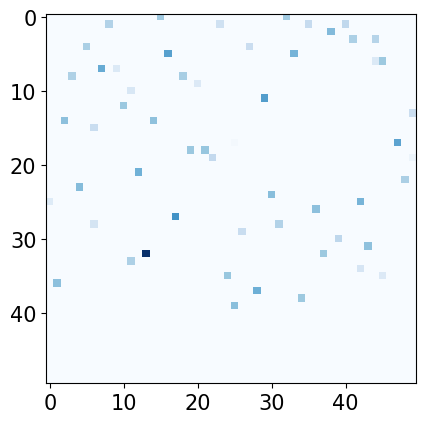

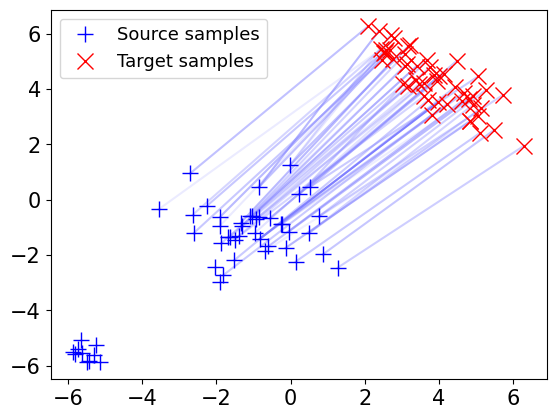

In [ ]:
G0 = ot.smooth.smooth_ot_dual(a * np.exp(-(u+zeta) / tau), b, cost + 100*s, 0.1, reg_type="l2")

pl.figure(3)
pl.imshow(G0, interpolation="nearest", cmap='Blues')
pl.tick_params(labelsize=15)

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, G0, c=[0.5, 0.5, 1])
pl.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples",markersize=12)
pl.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples",markersize=12)
sss = pl.legend(loc=0,fontsize = 13)
pl.tick_params(labelsize=15)

sss.set_draggable(True)

pl.show()

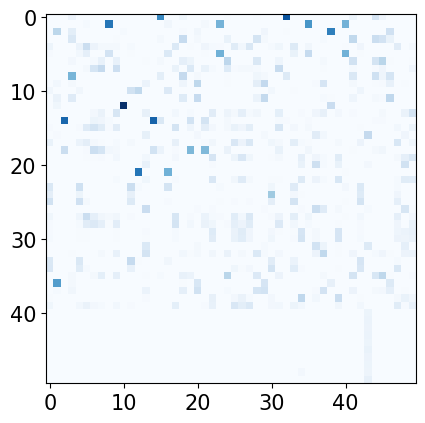

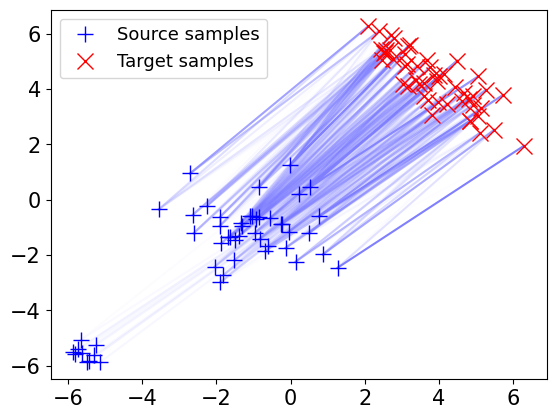

In [ ]:
pi_1 = ot.sinkhorn(a * np.exp(-(u+zeta)/tau), b, cost + 100 * s, 0.1)

pl.figure(3)
pl.imshow(pi_1, interpolation="nearest", cmap='Blues')
pl.tick_params(labelsize=15)

pl.figure(4)
ot.plot.plot2D_samples_mat(xs, xt, pi_1, c=[0.5, 0.5, 1])
pl.plot(xs[:, 0], xs[:, 1], "+b", label="Source samples",markersize=12)
pl.plot(xt[:, 0], xt[:, 1], "xr", label="Target samples",markersize=12)
sss = pl.legend(loc=0,fontsize = 13)
pl.tick_params(labelsize=15)

sss.set_draggable(True)

pl.show()